# TODO:





*   reach 0.5 at least on baseline
*   maybe see the worst segmented images
*   add testing pipeline
*   clean up
*   then work on another model



---



# ML4CV assignment
Jana Nikolovska


In [5]:
import os
from PIL import Image
import torchvision
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [6]:
try:
  del model, train_loader, val_loader
  torch.cuda.empty_cache()

  import torch

  if torch.cuda.is_available():
      print("Allocated:", round(torch.cuda.memory_allocated(0)/1024**2, 1), "MB")
      print("Cached:", round(torch.cuda.memory_reserved(0)/1024**2, 1), "MB")
except:
  print("Nothing deleted")

Nothing deleted


## Problem Statement

The task is anomaly detection through segmentation. Instead of directly predicting anomalies, the idea is to train a strong segmentation model on known classes and then use segmentation quality or derived metrics to identify unusual regions. This approach leverages spatial detail that pure classification would miss.

## Model Design
### Backbone

*   DeepLabV3-ResNet101 with ImageNet-pretrained weights.
*   The classifier head was replaced with a custom segmentation head and fine-tuned end-to-end.
*   Pretraining speeds up convergence and improves feature extraction

### Loss Functions

*   Cross-Entropy Loss handles multi-class separation.

*   Dice Loss focuses on overlap, crucial for imbalanced classes.

*   Combined into a Combo Loss for balanced learning.

### Data Processing

*   Resize to 768×768 for consistent input.

*   Augmentations: horizontal flip, color jitter, normalization.

*   Improves robustness to orientation and lighting.

*   Class Weights: computed and normalized to counter imbalance.

### Training Strategy

*   Optimizer: AdamW with weight decay.

*   Scheduler: Cosine Annealing for smooth LR decay.

*   Mixed Precision Training for efficiency.

*   Early Stopping on validation mIoU to avoid overfitting.

### Evaluation

*   Mean IoU (mIoU) chosen as the main metric, giving both per-class and overall performance.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [73]:
import os
from PIL import Image
import torchvision

COLORS = np.array([
    [  0,   0,   0],  # unlabeled    =   0,
    [ 70,  70,  70],  # building     =   1,
    [190, 153, 153],  # fence        =   2,
    [250, 170, 160],  # other        =   3,
    [220,  20,  60],  # pedestrian   =   4,
    [153, 153, 153],  # pole         =   5,
    [157, 234,  50],  # road line    =   6,
    [128,  64, 128],  # road         =   7,
    [244,  35, 232],  # sidewalk     =   8,
    [107, 142,  35],  # vegetation   =   9,
    [  0,   0, 142],  # car          =  10,
    [102, 102, 156],  # wall         =  11,
    [220, 220,   0],  # traffic sign =  12,
    [ 60, 250, 240],  # anomaly      =  13,
])


def color(annot_path: str, colors: np.ndarray) -> Image.Image:
    img_pil = Image.open(annot_path)
    img_np = np.array(img_pil)
    img_new = np.zeros((720, 1280, 3))

    for index, color in enumerate(colors):
        img_new[img_np == index + 1] = color

    return Image.fromarray(img_new.astype("uint8"), "RGB")

def process_folder(folder):
    print(f'Processing folder {folder}')
    # Paths to images and annotations folders
    images_folder = os.path.join(folder, "images")
    annotations_folder = os.path.join(folder, "annotations")

    # Initialize lists for images and annotations
    data = []

    # Traverse the images folder and process corresponding annotations
    for root, _, files in os.walk(images_folder):
        for image_file in files:
            if image_file.endswith((".png", ".jpg", ".jpeg")):
                # Construct paths for the image and corresponding annotation
                relative_path = os.path.relpath(root, images_folder)
                image_path = os.path.join(root, image_file)
                annotation_file = os.path.splitext(image_file)[0] + ".png"  # Assuming annotations are PNG images
                annotation_path = os.path.join(annotations_folder, relative_path, annotation_file)

                # Check if the corresponding annotation exists
                if os.path.exists(annotation_path):
                    try:
                        # Append the image file name, and image/annotation paths as a pair
                        # We will load the images in the Dataset __getitem__ to avoid keeping all images in memory
                        data.append((image_file, image_path, annotation_path))
                    except (IOError, SyntaxError) as e:
                        print(f"Warning: Skipping corrupted file pair for {image_file}. Error: {e}")
                else:
                    print(f"Warning: No annotation found for {image_file}")

    # Example: Print the number of images and annotations loaded
    print(f"Loaded {len(data)} image-annotation pairs.")
    return data

In [74]:
test_folder = '/content/drive/MyDrive/small_train'
test_data_full = process_folder(test_folder)
print(f"Data size {len(test_data_full)}")
print(f"Sample data {test_data_full[0]}")


val_folder = '/content/drive/MyDrive/small_validation'
val_data_full = process_folder(val_folder)
print(f"Data size {len(val_data_full)}")
print(f"Sample data {val_data_full[0]}")

Processing folder /content/drive/MyDrive/small_train
Loaded 1500 image-annotation pairs.
Data size 1500
Sample data ('105.png', '/content/drive/MyDrive/small_train/images/105.png', '/content/drive/MyDrive/small_train/annotations/./105.png')
Processing folder /content/drive/MyDrive/small_validation
Loaded 350 image-annotation pairs.
Data size 350
Sample data ('860.png', '/content/drive/MyDrive/small_validation/images/860.png', '/content/drive/MyDrive/small_validation/annotations/./860.png')


In [75]:
test_data = test_data_full
val_data = val_data_full

print(f"Test data size {len(test_data)}")
print(f"Val data size {len(val_data)}")

Test data size 1500
Val data size 350


/tmp/ipython-input-1851434135.py:31: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(img_new.astype("uint8"), "RGB")


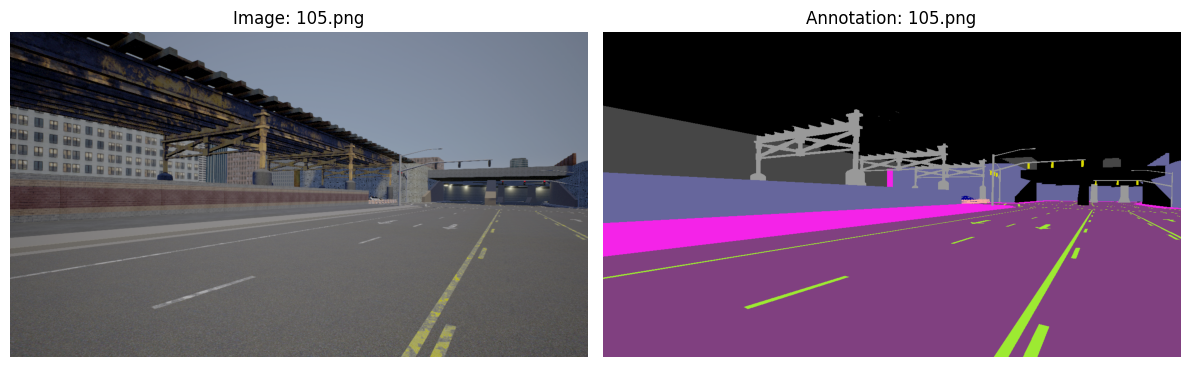

Sample image size (1280, 720)
Sample image size (1280, 720)


In [76]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Get a sample data pair (image file name, image path, annotation path)
if test_data:
    sample_image_file, sample_image_path, sample_annotation_path = test_data[0]

    try:
        # Load the image and annotation using PIL
        sample_image = Image.open(sample_image_path)
        sample_annotation = color(sample_annotation_path, COLORS)

        # Plot the image and annotation
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        axes[0].imshow(sample_image)
        axes[0].set_title(f"Image: {sample_image_file}")
        axes[0].axis('off')

        axes[1].imshow(sample_annotation, cmap='gray') # Use gray colormap for annotations
        axes[1].set_title(f"Annotation: {sample_image_file}")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Sample image size {sample_image.size}")
        print(f"Sample image size {sample_annotation.size}")


    except (IOError, SyntaxError) as e:
        print(f"Error loading or plotting sample file: {sample_image_file}. Error: {e}")
else:
    print("No data available to plot.")

In [77]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, path="best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"⚠️ EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
        print(f"✅ Model improved. Saved to {self.path}")

In [78]:
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import torchvision

from tqdm import tqdm

# ---------- helper: picklable conversion ----------
def pil_to_long_tensor(pic: Image.Image) -> torch.Tensor:
    # keeps values as ints; no normalization here
    arr = np.array(pic, dtype=np.int64)
    return torch.from_numpy(arr)

class SegmentationDataset(Dataset):
    """
    data: list of tuples (image_file_name, image_path, annotation_path)
    Annotations are assumed 1-based (1..K), ignore_index=255 untouched; we shift to 0-based.
    """
    def __init__(
        self,
        data,
        image_transform=None,
        annotation_transform=None,
        ignore_index=255,
        img_size=None,
        jitter=False,
        max_retry=8,
    ):
        self.data = data
        self.ignore_index = ignore_index
        self.max_retry = max_retry

        # Image transforms (safe defaults)
        if image_transform is None:
            it = []
            if img_size is not None:
                it.append(transforms.Resize((img_size, img_size), interpolation=InterpolationMode.BILINEAR))
            if jitter:
                it += [
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                ]
            it += [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ]
            self.image_transform = transforms.Compose(it)
        else:
            self.image_transform = image_transform

        # Annotation transforms (NEAREST + picklable fn)
        if annotation_transform is None:
            at = []
            if img_size is not None:
                at.append(transforms.Resize((img_size, img_size), interpolation=InterpolationMode.NEAREST))
            at.append(transforms.Lambda(pil_to_long_tensor))
            self.annotation_transform = transforms.Compose(at)
        else:
            self.annotation_transform = annotation_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Non-recursive retry loop to avoid infinite recursion on multiple bad files
        tries = 0
        N = len(self.data)
        while tries < self.max_retry:
            image_file, image_path, annotation_path = self.data[idx]

            try:
                # Ensure prompt closing of file handles (important on Colab/Drive)
                with Image.open(image_path) as img:
                    img = img.convert("RGB").copy()
                with Image.open(annotation_path) as ann:
                    ann = ann.convert("L").copy()

                if self.image_transform:
                    img = self.image_transform(img)
                if self.annotation_transform:
                    ann = self.annotation_transform(ann)  # int64 tensor [H,W]

                # shift 1-based labels to 0-based; keep ignore_index as-is
                if self.ignore_index is not None:
                    ignore_mask = (ann == self.ignore_index)
                    ann = torch.where(ignore_mask, ann, ann - 1)
                else:
                    ann = ann - 1

                # clamp just in case (avoid negatives from background=0 → -1)
                # if your original labels start at 1, this keeps background at 0 after shift
                ann = torch.clamp(ann, min=0, max=ann.max())

                return img, ann

            except (OSError, ValueError) as e:
                print(f"[Dataset] Skipping corrupted file: {image_file}. Error: {e}")
                idx = (idx + 1) % N
                tries += 1

        raise RuntimeError(f"[Dataset] Too many corrupted files in a row (>{self.max_retry}).")

def create_segmentation_datasets(train_data, val_data, img_size=512):
    train_dataset = SegmentationDataset(train_data, img_size=img_size, jitter=False)
    val_dataset   = SegmentationDataset(val_data,   img_size=img_size, jitter=False)
    return train_dataset, val_dataset

def get_dataloaders(train_dataset, val_dataset, batch_size=4, num_workers=0):
    # Start with num_workers=0 for stability; bump to 2 later if desired
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=torch.cuda.is_available(),
        persistent_workers=True, drop_last=False
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=torch.cuda.is_available(),
        persistent_workers=True
    )
    return train_loader, val_loader


In [79]:
batch_size = 8
num_classes = 13
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset, val_dataset = create_segmentation_datasets(test_data, val_data)  # your lists
train_loader, val_loader = get_dataloaders(train_dataset, val_dataset, batch_size, num_workers=2)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")
xb, yb = next(iter(train_loader))
print("One batch shapes:", xb.shape, yb.shape)

Train dataset size: 1500, Validation dataset size: 350
One batch shapes: torch.Size([8, 3, 512, 512]) torch.Size([8, 512, 512])


In [80]:
import torch

def check_dataset(train_dataset, num_classes, expected_channels=3, ignore_index=255):
    """
    Checks all images and annotations in the dataset.
    - Annotations: must be in [0, num_classes-1] or ignore_index
    - Images: must have expected_channels and values in [0,1]
    """
    annotation_issues = False
    image_issues = False

    for idx, (image, annotation) in enumerate(train_dataset):
        # ---------- Check annotation ----------
        if annotation.dim() == 3 and annotation.shape[0] == 1:
            annotation = annotation.squeeze(0)

        mask_invalid = (annotation < 0) | ((annotation >= num_classes) & (annotation != ignore_index))
        if mask_invalid.any():
            annotation_issues = True
            num_invalid = mask_invalid.sum().item()
            print(f"[!] Sample {idx}: Invalid annotation values ({num_invalid} pixels)")
            print(f"    Min: {annotation.min().item()}, Max: {annotation.max().item()}")

        # Ensure annotation is long
        if annotation.dtype != torch.long:
            print(f"[!] Sample {idx}: Annotation dtype is {annotation.dtype}, should be torch.long")

        # ---------- Check image ----------
        if image.dim() != 3:
            image_issues = True
            print(f"[!] Sample {idx}: Image dimension {image.shape} invalid (expected 3D tensor)")
        elif image.shape[0] != expected_channels:
            image_issues = True
            print(f"[!] Sample {idx}: Image channels {image.shape[0]} invalid (expected {expected_channels})")

        if image.min() < 0.0 or image.max() > 1.0:
            image_issues = True
            print(f"[!] Sample {idx}: Image values out of range [{image.min().item()}, {image.max().item()}]")

    if not annotation_issues:
        print("[✔] All annotations are valid.")
    if not image_issues:
        print("[✔] All images are valid.")


#check_dataset(train_dataset, num_classes, expected_channels=3, ignore_index=255)

In [81]:
# model = get_model(num_classes)
# train_model(model, train_loader, val_loader, num_epochs, device, num_classes)

In [82]:
from collections import Counter
import torch

def compute_class_weights_from_loader(loader, num_classes, ignore_index=255, max_batches=None):
    """
    Fast class weight computation using torch.bincount over batches already in RAM.
    Set max_batches (e.g., 50) to sample the loader for speed.
    """
    counts = torch.zeros(num_classes, dtype=torch.long)
    processed_batches = 0

    print(f"Dataset size: {len(loader.dataset)}")
    print(f"Batch size: {loader.batch_size}")
    print(f"Number of batches: {len(loader)}")


    for i, (_, ann) in enumerate(loader):
        print("i")
        # [B,H,W] or [B,1,H,W] -> [B,H,W]
        if ann.dim() == 4 and ann.shape[1] == 1:
            ann = ann.squeeze(1)

        mask = (ann != ignore_index)
        valid = ann[mask].view(-1)

        if valid.numel() > 0:
            binc = torch.bincount(valid, minlength=num_classes)
            counts += binc[:num_classes].cpu()

        processed_batches += 1
        if (max_batches is not None) and (processed_batches >= max_batches):
            break

    counts = counts.clamp_min(1)
    total = counts.sum().item()

    # inverse frequency, normalized so mean≈1
    weights = (total / (counts.float() * num_classes))
    weights = weights * (num_classes / weights.sum())
    return weights


In [83]:
import logging

# Setup logger at the start of the script/function
def setup_logger(model_name, timestamp):
    log_path = f"{model_name}_{timestamp}.log"
    logger = logging.getLogger(model_name)
    logger.setLevel(logging.INFO)

    # File handler
    fh = logging.FileHandler(log_path)
    fh.setLevel(logging.INFO)

    # Formatter
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    fh.setFormatter(formatter)

    # Add handler
    if logger.hasHandlers():
        logger.handlers.clear()
    logger.addHandler(fh)
    return logger


In [84]:
def _gt_edge_band(labels, band_px=3, ignore_index=255):
    """
    labels: (B,H,W) long
    returns: (B,H,W) bool mask for pixels within a band around GT edges
    """
    if labels.dim() == 2:
        labels = labels.unsqueeze(0)
    B, H, W = labels.shape
    device = labels.device

    valid = (labels != ignore_index)
    safe  = labels.clone()
    safe[~valid] = -1  # so ignored never matches neighbors

    # 8-neighbor difference -> edge map (B,1,H,W)
    k = torch.ones(1, 1, 3, 3, device=device, dtype=torch.float32)
    k[:, :, 1, 1] = 0.0
    # compare equality with neighbors by convolving each label plane as floats
    # trick: for eq count, we convolve boolean (safe == center)
    c = safe.float().unsqueeze(1)  # (B,1,H,W)
    # build per-neighbor equality by shifting via conv on one-hot? simpler: gradient-like test:
    # we mark an edge where any neighbor differs.
    # Compute max and min in 3x3 window; if different -> there is a boundary
    max_win = F.max_pool2d(c, 3, 1, 1)
    min_win = -F.max_pool2d(-c, 3, 1, 1)
    edges = ((max_win != min_win).float() * valid.unsqueeze(1).float())  # (B,1,H,W)

    # expand to a band (dilate)
    r = max(1, int(band_px))
    for _ in range(r):
        edges = F.max_pool2d(edges, kernel_size=3, stride=1, padding=1)
    return edges.squeeze(1).bool()  # (B,H,W)

def compute_trimap_miou(outputs, targets, num_classes, band_px=3, ignore_index=255):
    """
    outputs: logits (B,C,H,W), targets: (B,H,W)
    returns: (per_class_iou_in_band, mean_iou_in_band)
    """
    with torch.no_grad():
        preds = torch.argmax(outputs, dim=1)  # (B,H,W)
        preds_np = preds.detach().cpu().numpy()
        t_np     = targets.detach().cpu().numpy()

        # valid + band (PyTorch to build band robustly)
        band_mask = _gt_edge_band(targets, band_px=band_px, ignore_index=ignore_index)  # (B,H,W) bool
        band_np   = band_mask.cpu().numpy()

        per_cls = []
        for cls in range(num_classes):
            pm = (preds_np == cls) & band_np & (t_np != ignore_index)
            tm = (t_np == cls)    & band_np
            inter = np.logical_and(pm, tm).sum()
            union = np.logical_or(pm, tm).sum()
            per_cls.append(float(inter) / union if union > 0 else float("nan"))
        return per_cls, float(np.nanmean(per_cls))


/tmp/ipython-input-1851434135.py:31: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(img_new.astype("uint8"), "RGB")


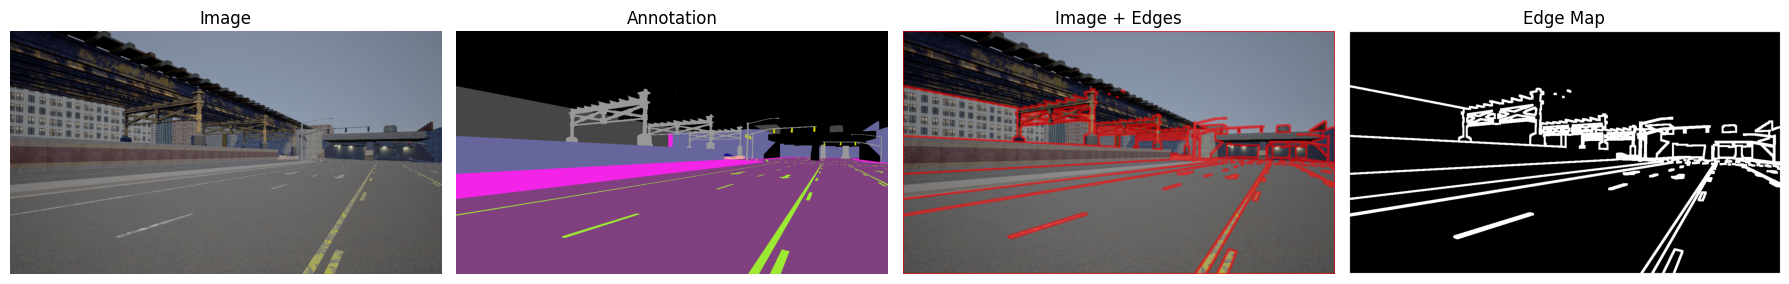

Image size: (1280, 720) | Annotation size: (1280, 720) | Edge pixels: 105474 (11.44%)


In [85]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F

import torch
import torch.nn.functional as F

def sobel_edges_from_labels(labels, num_classes=None, ignore_index=255, dilate=1, thresh=1e-4):
    """
    labels: (H,W) or (B,H,W) long
    returns: (B,1,H,W) float in {0,1}
    """
    if not torch.is_tensor(labels):
        labels = torch.as_tensor(labels)
    if labels.dim() == 2:
        labels = labels.unsqueeze(0)  # (1,H,W)
    labels = labels.long()
    device = labels.device
    B, H, W = labels.shape

    valid = (labels != ignore_index)
    if valid.sum().item() == 0:
        return torch.zeros((B,1,H,W), device=device, dtype=torch.float32)

    safe = labels.clone()
    safe[~valid] = 0

    if num_classes is None or int(num_classes) <= 0:
        num_classes = int(safe.max().item() + 1)
    C = int(num_classes)

    onehot = torch.zeros(B, C, H, W, device=device, dtype=torch.float32)
    onehot.scatter_(1, safe.unsqueeze(1), 1.0)
    onehot *= valid.unsqueeze(1).float()

    kx_base = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=torch.float32, device=device).view(1,1,3,3)
    ky_base = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=torch.float32, device=device).view(1,1,3,3)
    kx = kx_base.repeat(C, 1, 1, 1)  # (C,1,3,3)
    ky = ky_base.repeat(C, 1, 1, 1)  # (C,1,3,3)

    gx = F.conv2d(onehot, kx, padding=1, groups=C)  # (B,C,H,W)
    gy = F.conv2d(onehot, ky, padding=1, groups=C)  # (B,C,H,W)
    g  = torch.sqrt(gx*gx + gy*gy)                  # <-- no epsilon here

    gsum  = g.sum(dim=1, keepdim=True)              # (B,1,H,W)
    edges = (gsum > thresh).to(torch.float32)       # <-- threshold guards noise
    edges *= valid.unsqueeze(1).float()

    if dilate and int(dilate) > 0:
        for _ in range(int(dilate)):
            edges = F.max_pool2d(edges, kernel_size=3, stride=1, padding=1)

    return edges  # (B,1,H,W)



# ===== Visual demo: image | annotation | overlay | edge map =====
def show_edges(sample_image_path, sample_annotation_path, num_classes=None, ignore_index=255, dilate=1, COLORS=None):
    img_pil = Image.open(sample_image_path).convert("RGB")
    img_np  = np.array(img_pil)

    label_pil = Image.open(sample_annotation_path).convert("L")  # if your labels are *color-coded*, map to IDs first
    label_np  = np.array(label_pil).astype(np.int64)

    if num_classes is None:
        uniq = np.unique(label_np[label_np != ignore_index])
        num_classes = int(uniq.max() + 1) if uniq.size > 0 else 1

    labels_t = torch.from_numpy(label_np).to(torch.long)
    with torch.no_grad():
        edges_t = sobel_edges_from_labels(labels_t, num_classes=num_classes, ignore_index=ignore_index,
                                          dilate=2, thresh=1e-4)   # try 1e-3 if still too thick
    edges_np = edges_t.squeeze().cpu().numpy().astype(bool)

    try:
        color_mask_pil = color(sample_annotation_path, COLORS) if COLORS is not None else Image.fromarray(label_np)
    except Exception:
        color_mask_pil = Image.fromarray(label_np)

    overlay = img_np.copy()
    red = np.array([255, 0, 0], dtype=np.uint8)
    alpha = 0.6
    overlay[edges_np] = (alpha * red + (1 - alpha) * overlay[edges_np]).astype(np.uint8)

    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    axes[0].imshow(img_np);                 axes[0].set_title("Image"); axes[0].axis('off')
    axes[1].imshow(color_mask_pil);         axes[1].set_title("Annotation"); axes[1].axis('off')
    axes[2].imshow(overlay);                axes[2].set_title("Image + Edges"); axes[2].axis('off')
    axes[3].imshow(edges_np, cmap='gray');  axes[3].set_title("Edge Map"); axes[3].axis('off')
    plt.tight_layout(); plt.show()

    H, W = label_np.shape
    print(f"Image size: {img_pil.size} | Annotation size: {label_pil.size} | "
          f"Edge pixels: {edges_np.sum()} ({edges_np.sum()/(H*W):.2%})")

# ===== Example usage with your test_data tuple list =====
if test_data:
    fname, img_path, ann_path = test_data[0]
    show_edges(img_path, ann_path, num_classes=None, ignore_index=255, dilate=1, COLORS=COLORS if 'COLORS' in globals() else None)
else:
    print("No data available to plot.")


In [86]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from PIL import Image
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
import numpy as np
from PIL import Image
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import datetime

from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.models.segmentation.deeplabv3 import DeepLabV3, DeepLabHead

# ---------- Edge aux head ----------
# ---------- Edge aux head ----------
class EdgeHead(nn.Module):
    # ResNet101 layer2 -> 512 channels
    def __init__(self, in_ch=512):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(256, 1, kernel_size=1)
        )
    def forward(self, x):
        return self.block(x)



# ---------- Model Setup: OS=8 main head, aux from layer2 (stride 8, 256ch) ----------
def get_model(num_classes):
    # Output stride 8: dilate layer3 & layer4
    backbone = resnet101(
        weights=ResNet101_Weights.DEFAULT,
        replace_stride_with_dilation=[False, True, True]
    )
    # expose layer4 for 'out' and layer2 for 'aux'
    return_layers = {'layer4': 'out', 'layer2': 'aux'}
    backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

    model = DeepLabV3(backbone, classifier=DeepLabHead(2048, num_classes))
    model.aux_classifier = EdgeHead(in_ch=512)  # <-- must be 512
    return model


# ---------- Dice + Combo Loss (unchanged) ----------
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6, ignore_index=255):
        super().__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index
    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        valid = (targets != self.ignore_index)
        safe_targets = targets.clone(); safe_targets[~valid] = 0
        targets_one_hot = torch.zeros_like(probs).scatter_(1, safe_targets.unsqueeze(1), 1)
        mask = valid.unsqueeze(1).to(probs.dtype)
        probs = probs * mask; targets_one_hot = targets_one_hot * mask
        dims = (0,2,3)
        inter = (probs * targets_one_hot).sum(dim=dims)
        card  = probs.sum(dim=dims) + targets_one_hot.sum(dim=dims)
        dice  = (2.0 * inter + self.smooth) / (card + self.smooth)
        return 1.0 - dice.mean()

class ComboLoss(nn.Module):
    def __init__(self, weight=None, ce_weight=1.0, dice_weight=2.0, ignore_index=255, label_smoothing=0.0):
        super().__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.ce = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index, label_smoothing=label_smoothing)
        self.dice = DiceLoss(ignore_index=ignore_index)
    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        dice_loss = self.dice(logits, targets)
        total = self.ce_weight * ce_loss + self.dice_weight * dice_loss
        return total, ce_loss, dice_loss

# ---------- mIoU (unchanged) ----------
def compute_miou(outputs, targets, num_classes, ignore_index=255, ignore_anomaly_index=None):
    preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    valid = (targets != ignore_index)
    if ignore_anomaly_index is not None: valid &= (targets != ignore_anomaly_index)
    preds = preds[valid]; targets = targets[valid]
    ious = []
    for cls in range(num_classes):
        pm = (preds == cls); tm = (targets == cls)
        inter = np.logical_and(pm, tm).sum()
        union = np.logical_or(pm, tm).sum()
        ious.append(float(inter) / union if union > 0 else float("nan"))
    return ious, np.nanmean(ious)

# ---------- Robust Sobel edges from label IDs ----------
def sobel_edges_from_labels(labels, num_classes=None, ignore_index=255, dilate=1, thresh=1e-4):
    """
    labels: (H,W) or (B,H,W) long tensor of class IDs
    returns: (B,1,H,W) float {0,1} edges (ignored -> 0)
    """
    if not torch.is_tensor(labels): labels = torch.as_tensor(labels)
    if labels.dim() == 2: labels = labels.unsqueeze(0)
    labels = labels.long()
    device = labels.device
    B, H, W = labels.shape
    valid = (labels != ignore_index)
    if valid.sum().item() == 0:
        return torch.zeros((B,1,H,W), device=device, dtype=torch.float32)

    safe = labels.clone(); safe[~valid] = 0
    if num_classes is None or int(num_classes) <= 0:
        num_classes = int(safe.max().item() + 1)
    C = int(num_classes)

    onehot = torch.zeros(B, C, H, W, device=device, dtype=torch.float32)
    onehot.scatter_(1, safe.unsqueeze(1), 1.0)
    onehot *= valid.unsqueeze(1).float()

    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=torch.float32, device=device).view(1,1,3,3).repeat(C,1,1,1)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=torch.float32, device=device).view(1,1,3,3).repeat(C,1,1,1)

    gx = F.conv2d(onehot, kx, padding=1, groups=C)
    gy = F.conv2d(onehot, ky, padding=1, groups=C)
    g  = torch.sqrt(gx*gx + gy*gy)
    gsum = g.sum(dim=1, keepdim=True)
    edges = (gsum > thresh).float()
    edges *= valid.unsqueeze(1).float()

    if dilate and int(dilate) > 0:
        for _ in range(int(dilate)):
            edges = F.max_pool2d(edges, kernel_size=3, stride=1, padding=1)
    return edges

# ---------- Training Loop (edge loss wired in + logged) ----------
def train_model(model, train_loader, val_loader, num_epochs, device, num_classes,
                model_name="seg_model", patience=5, maxlogit_thresholds=[1.0, 2.0, 3.0],
                label_smoothing=0.1, freeze_backbone=True, edge_lambda=0.6, edge_pos_weight=4.0):

    timestamp = datetime.datetime.now().strftime("%d%m%H%M")
    ckpt_path = f"{model_name}_{timestamp}.pth"
    logger = setup_logger(model_name, timestamp)

    model = model.to(device)

    if freeze_backbone and hasattr(model, "backbone"):
        for name, param in model.backbone.named_parameters():
            if any(layer in name for layer in ["layer1", "layer2"]):
                param.requires_grad = False
        logger.info("✅ Frozen ResNet backbone layers: layer1 & layer2")

    # class weights
    try:
        class_weights = torch.load("/content/class_weights.pt").to(device)
        logger.info("✅ Loaded cached class weights.")
    except FileNotFoundError:
        logger.info("🔄 Computing class weights...")
        class_weights = compute_class_weights_from_loader(
            train_loader, num_classes=num_classes, ignore_index=255, max_batches=50
        ).to(device)
        torch.save(class_weights.cpu(), "/content/class_weights.pt")
        logger.info("💾 Saved class weights to /content/class_weights.pt")

    class_weights = torch.sqrt(class_weights)
    class_weights = class_weights / class_weights.sum() * num_classes
    logger.info(f"📊 Final normalized class weights: {class_weights}")

    criterion = ComboLoss(weight=class_weights, ignore_index=255, label_smoothing=label_smoothing)
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=2, eta_min=1e-5)
    scaler = torch.cuda.amp.GradScaler()
    early_stopping = EarlyStopping(patience=patience, path=ckpt_path)

    # 🔹 add 'trimap_iou' to history
    history = {
        "loss": [], "ce_loss": [], "dice_loss": [], "edge_loss": [],
        "mean_iou": [], "per_class_iou": [], "trimap_iou": [],
        "maxlogit_mean": [], "maxlogit_std": [], "low_conf_pct": {th: [] for th in maxlogit_thresholds}
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = running_ce = running_dice = running_edge = 0.0

        for batch_idx, (images, annotations) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images, annotations = images.to(device), annotations.to(device)
            if annotations.dim() == 4 and annotations.shape[1] == 1:
                annotations = annotations.squeeze(1)
            annotations = annotations.long()

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)            # {'out', 'aux'}
                seg_logits  = outputs['out']
                edge_logits = outputs.get('aux', None)
                if edge_logits is None:
                    raise RuntimeError("Edge aux head not found. Ensure model.aux_classifier is defined.")
                edge_logits = F.interpolate(edge_logits, size=annotations.shape[-2:], mode='bilinear', align_corners=False)

                seg_total, ce_loss, dice_loss = criterion(seg_logits, annotations)

                # NOTE: set dilate=2 if you want thicker targets as discussed
                edge_targets = sobel_edges_from_labels(annotations, num_classes, ignore_index=255, dilate=2, thresh=1e-4)
                pos_w = torch.tensor([edge_pos_weight], device=device, dtype=torch.float32)
                edge_loss = F.binary_cross_entropy_with_logits(edge_logits, edge_targets, pos_weight=pos_w)

                loss = seg_total + edge_lambda * edge_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step(epoch + batch_idx / max(1, len(train_loader)))

            running_loss += float(loss.item())
            running_ce   += float(ce_loss.item())
            running_dice += float(dice_loss.item())
            running_edge += float(edge_loss.item())

        n_batches = max(1, len(train_loader))
        avg_loss = running_loss / n_batches
        avg_ce   = running_ce   / n_batches
        avg_dice = running_dice / n_batches
        avg_edge = running_edge / n_batches

        logger.info(f"📉 Epoch {epoch+1}/{num_epochs} | Total: {avg_loss:.4f} | CE: {avg_ce:.4f} | "
                    f"Dice: {avg_dice:.4f} | Edge: {avg_edge:.4f} (λ={edge_lambda})")

        # 🔹 validation now returns Trimap IoU too
        per_class_iou, mean_miou, trimap_miou = validate_model(
            model, val_loader, device, num_classes, logger=logger,
            maxlogit_thresholds=maxlogit_thresholds, trimap_band_px=3  # 3px band; tune 3–5
        )

        history["loss"].append(avg_loss)
        history["ce_loss"].append(avg_ce)
        history["dice_loss"].append(avg_dice)
        history["edge_loss"].append(avg_edge)
        history["mean_iou"].append(mean_miou)
        history["per_class_iou"].append(per_class_iou)
        history["trimap_iou"].append(trimap_miou)   # 🔹 record it

        with torch.no_grad():
            all_maxlogits = []
            for images, _ in val_loader:
                images = images.to(device)
                logits = model(images)['out']
                max_logits, _ = torch.max(logits, dim=1)
                all_maxlogits.append(max_logits)
            all_maxlogits = torch.cat([x.flatten() for x in all_maxlogits])
            history["maxlogit_mean"].append(all_maxlogits.mean().item())
            history["maxlogit_std"].append(all_maxlogits.std().item())
            for th in maxlogit_thresholds:
                history["low_conf_pct"][th].append(((all_maxlogits < th).float().mean().item()) * 100)

        early_stopping(mean_miou, model)
        if early_stopping.early_stop:
            logger.info("⏹️ Early stopping triggered!")
            break

    model.load_state_dict(torch.load(ckpt_path))
    return model, history, ckpt_path



# =========================
# Validation Loop
# =========================
def validate_model(model, val_loader, device, num_classes, logger=None, ignore_index=255, maxlogit_thresholds=[1.0, 2.0, 3.0],
                   trimap_band_px=3):
    """
    Returns:
      mean_per_class (standard IoU per class),
      mean_miou (standard),
      trimap_miou (IoU inside a band around GT edges)
    """
    model.eval()
    all_ious = []

    maxlogit_means = []
    maxlogit_stds = []
    low_conf_percentages = {th: [] for th in maxlogit_thresholds}

    trimap_scores = []

    with torch.no_grad():
        for images, annotations in val_loader:
            images, annotations = images.to(device), annotations.to(device)
            if annotations.dim() == 4 and annotations.shape[1] == 1:
                annotations = annotations.squeeze(1)
            annotations = annotations.long()

            outputs = model(images)['out']

            # Standard IoU
            ious, _ = compute_miou(outputs, annotations, num_classes, ignore_index)
            all_ious.append(ious)

            # Trimap IoU (edge band)
            _, tri_mean = compute_trimap_miou(outputs, annotations, num_classes,
                                              band_px=trimap_band_px, ignore_index=ignore_index)
            trimap_scores.append(tri_mean)

            # MaxLogit stats
            max_logits, _ = torch.max(outputs, dim=1)  # (B,H,W)
            maxlogit_means.append(max_logits.mean().item())
            maxlogit_stds.append(max_logits.std().item())
            for th in maxlogit_thresholds:
                low_conf = (max_logits < th).float().mean().item() * 100
                low_conf_percentages[th].append(low_conf)

    all_ious = np.array(all_ious)
    mean_per_class = np.nanmean(all_ious, axis=0)
    mean_miou = np.nanmean(mean_per_class)
    trimap_miou = float(np.mean(trimap_scores)) if len(trimap_scores) else float("nan")

    if logger:
        logger.info(f"Per-class IoU: {np.round(mean_per_class, 3)}")
        logger.info(f"Mean IoU: {round(mean_miou, 3)} | Trimap IoU@{trimap_band_px}px: {trimap_miou:.3f}")
        logger.info(f"MaxLogit Mean: {np.mean(maxlogit_means):.3f}, Std: {np.mean(maxlogit_stds):.3f}")
        for th in maxlogit_thresholds:
            logger.info(f"Avg. % of pixels with MaxLogit < {th}: {np.mean(low_conf_percentages[th]):.2f}%")
    else:
        print("Per-class IoU:", np.round(mean_per_class, 3))
        print("Mean IoU:", round(mean_miou, 3), f"| Trimap IoU@{trimap_band_px}px:", f"{trimap_miou:.3f}")

    return mean_per_class, mean_miou, trimap_miou


# =========================
# Plotting Function
# =========================

def plot_training_curves(history, model_name="seg_model"):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(18, 5))

    # --- Losses ---
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["loss"], label="Total Loss")
    plt.plot(epochs, history["ce_loss"], label="CE Loss")
    plt.plot(epochs, history["dice_loss"], label="Dice Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss Curves")
    plt.legend()
    plt.grid(True)

    # --- Mean IoU ---
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["mean_iou"], label="Mean IoU", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Mean IoU")
    plt.title(f"{model_name} - Mean IoU")
    plt.legend()
    plt.grid(True)

    # --- MaxLogit Stats ---
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["maxlogit_mean"], label="MaxLogit Mean", color="blue")
    plt.plot(epochs, history["maxlogit_std"], label="MaxLogit Std", color="orange")

    # Plot low-confidence % for each threshold
    for th, values in history["low_conf_pct"].items():
        plt.plot(epochs, values, label=f"% pixels < {th}", linestyle="--")

    plt.xlabel("Epochs")
    plt.ylabel("MaxLogit / Low-Confidence %")
    plt.title(f"{model_name} - MaxLogit Statistics")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Optional: per-class IoU
    if history["per_class_iou"]:
        per_class_iou = np.array(history["per_class_iou"])
        plt.figure(figsize=(12, 6))
        for cls in range(per_class_iou.shape[1]):
            plt.plot(epochs, per_class_iou[:, cls], label=f"Class {cls}")
        plt.xlabel("Epochs")
        plt.ylabel("IoU")
        plt.title(f"{model_name} - Per-Class IoU")
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
model = get_model(num_classes)
model, history, ckpt_path = train_model(model, train_loader, val_loader, num_epochs, device, num_classes, patience = 5)

INFO:seg_model:✅ Frozen ResNet backbone layers: layer1 & layer2
INFO:seg_model:✅ Loaded cached class weights.
INFO:seg_model:📊 Final normalized class weights: tensor([0.1197, 0.1896, 0.5985, 1.0508, 5.3489, 0.5955, 0.5716, 0.1156, 0.2582,
        0.2201, 1.3586, 0.3801, 2.1928], device='cuda:0')
/tmp/ipython-input-442692144.py:185: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/100:   0%|          | 0/188 [00:00<?, ?it/s]/tmp/ipython-input-442692144.py:206: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/100: 100%|██████████| 188/188 [11:33<00:00,  3.69s/it]
INFO:seg_model:📉 Epoch 1/100 | Total: 3.8324 | CE: 2.3679 | Dice: 0.5948 | Edge: 0.4580 (λ=0.6)
INFO:seg_model:Per-class IoU: [0.851 0.785 0.386 0.334 0.008 0.233 0.496 0.915 0.677 0.785 0.21

✅ Model improved. Saved to seg_model_06111409.pth


Epoch 2/100: 100%|██████████| 188/188 [00:49<00:00,  3.77it/s]
INFO:seg_model:📉 Epoch 2/100 | Total: 3.4419 | CE: 2.2007 | Dice: 0.5096 | Edge: 0.3702 (λ=0.6)
INFO:seg_model:Per-class IoU: [0.856 0.811 0.46  0.308 0.008 0.262 0.519 0.916 0.682 0.792 0.244 0.418
 0.238]
INFO:seg_model:Mean IoU: 0.501 | Trimap IoU@3px: 0.373
INFO:seg_model:MaxLogit Mean: 3.188, Std: 0.588
INFO:seg_model:Avg. % of pixels with MaxLogit < 1.0: 0.18%
INFO:seg_model:Avg. % of pixels with MaxLogit < 2.0: 4.37%
INFO:seg_model:Avg. % of pixels with MaxLogit < 3.0: 22.03%


✅ Model improved. Saved to seg_model_06111409.pth


Epoch 3/100: 100%|██████████| 188/188 [00:49<00:00,  3.76it/s]
INFO:seg_model:📉 Epoch 3/100 | Total: 3.3878 | CE: 2.1819 | Dice: 0.4975 | Edge: 0.3516 (λ=0.6)
INFO:seg_model:Per-class IoU: [0.86  0.807 0.459 0.344 0.009 0.267 0.511 0.917 0.689 0.8   0.265 0.403
 0.236]
INFO:seg_model:Mean IoU: 0.505 | Trimap IoU@3px: 0.377
INFO:seg_model:MaxLogit Mean: 3.246, Std: 0.588
INFO:seg_model:Avg. % of pixels with MaxLogit < 1.0: 0.17%
INFO:seg_model:Avg. % of pixels with MaxLogit < 2.0: 3.92%
INFO:seg_model:Avg. % of pixels with MaxLogit < 3.0: 18.58%


✅ Model improved. Saved to seg_model_06111409.pth


Epoch 4/100: 100%|██████████| 188/188 [00:49<00:00,  3.77it/s]
INFO:seg_model:📉 Epoch 4/100 | Total: 3.3826 | CE: 2.1839 | Dice: 0.4957 | Edge: 0.3456 (λ=0.6)
INFO:seg_model:Per-class IoU: [0.856 0.805 0.48  0.326 0.007 0.296 0.5   0.913 0.686 0.805 0.265 0.403
 0.253]
INFO:seg_model:Mean IoU: 0.507 | Trimap IoU@3px: 0.380
INFO:seg_model:MaxLogit Mean: 3.267, Std: 0.610
INFO:seg_model:Avg. % of pixels with MaxLogit < 1.0: 0.22%
INFO:seg_model:Avg. % of pixels with MaxLogit < 2.0: 3.98%
INFO:seg_model:Avg. % of pixels with MaxLogit < 3.0: 17.80%


✅ Model improved. Saved to seg_model_06111409.pth


Epoch 5/100: 100%|██████████| 188/188 [00:49<00:00,  3.77it/s]
INFO:seg_model:📉 Epoch 5/100 | Total: 3.3422 | CE: 2.1747 | Dice: 0.4859 | Edge: 0.3262 (λ=0.6)
INFO:seg_model:Per-class IoU: [0.855 0.793 0.476 0.302 0.006 0.282 0.51  0.918 0.704 0.809 0.251 0.452
 0.285]
INFO:seg_model:Mean IoU: 0.511 | Trimap IoU@3px: 0.388
INFO:seg_model:MaxLogit Mean: 3.246, Std: 0.611
INFO:seg_model:Avg. % of pixels with MaxLogit < 1.0: 0.21%
INFO:seg_model:Avg. % of pixels with MaxLogit < 2.0: 4.08%
INFO:seg_model:Avg. % of pixels with MaxLogit < 3.0: 20.10%


✅ Model improved. Saved to seg_model_06111409.pth


Epoch 6/100: 100%|██████████| 188/188 [00:49<00:00,  3.79it/s]
INFO:seg_model:📉 Epoch 6/100 | Total: 3.3125 | CE: 2.1665 | Dice: 0.4792 | Edge: 0.3126 (λ=0.6)
INFO:seg_model:Per-class IoU: [0.863 0.808 0.478 0.321 0.005 0.275 0.524 0.923 0.729 0.821 0.256 0.389
 0.268]
INFO:seg_model:Mean IoU: 0.512 | Trimap IoU@3px: 0.394
INFO:seg_model:MaxLogit Mean: 3.264, Std: 0.593
INFO:seg_model:Avg. % of pixels with MaxLogit < 1.0: 0.27%
INFO:seg_model:Avg. % of pixels with MaxLogit < 2.0: 3.90%
INFO:seg_model:Avg. % of pixels with MaxLogit < 3.0: 16.91%


✅ Model improved. Saved to seg_model_06111409.pth


Epoch 7/100:  61%|██████    | 114/188 [00:30<00:18,  4.09it/s]

In [ ]:
plot_training_curves(history, "Baseline model")

In [ ]:
import torch
import json
import numpy as np
from pathlib import Path

def save_model_and_history(model, history, save_dir, model_name="seg_model"):
    """
    Saves model weights (.pth) and training history (.json).

    Converts NumPy arrays/scalars in `history` to JSON-safe types.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # --- Save model weights ---
    weights_path = Path(save_dir) / f"{model_name}.pth"
    torch.save(model.state_dict(), weights_path)

    # --- Convert history to JSON-safe format ---
    def make_json_safe(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (np.float32, np.float64, np.int32, np.int64)):
            return obj.item()
        elif isinstance(obj, dict):
            return {k: make_json_safe(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [make_json_safe(v) for v in obj]
        else:
            return obj

    safe_history = make_json_safe(history)

    # --- Save as JSON ---
    history_path = Path(save_dir) / f"{model_name}_history.json"
    with open(history_path, "w") as f:
        json.dump(safe_history, f, indent=4)

    print(f"✅ Saved model weights → {weights_path}")
    print(f"✅ Saved training history → {history_path}")

save_model_and_history(model, history, "/checkpoints", model_name="seg_model")


In [ ]:
import torch
import json
from pathlib import Path

def load_model_and_history(model, load_dir, model_name="seg_model", map_location=None):
    """
    Loads model weights (.pth) and training history (.json).

    Args:
        model: initialized model architecture (same as used for training)
        load_dir: folder path where files are stored
        model_name: base name for files (no extension)
        map_location: device mapping for torch.load (e.g., 'cpu' or 'cuda:0')

    Returns:
        model: model with loaded weights
        history: dict containing training metrics (if file exists)
    """
    load_dir = Path(load_dir)
    weights_path = load_dir / f"{model_name}.pth"
    history_path = load_dir / f"{model_name}_history.json"

    # Load weights
    model.load_state_dict(torch.load(weights_path, map_location=map_location))
    print(f"✅ Loaded model weights from → {weights_path}")

    # Load history if available
    if history_path.exists():
        with open(history_path, "r") as f:
            history = json.load(f)
        print(f"✅ Loaded training history from → {history_path}")
    else:
        print("⚠️ No history file found; returning empty dict.")
        history = {}

    return model, history


In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def denorm(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    # img_tensor: [3,H,W], normalized
    m = torch.tensor(mean, device=img_tensor.device)[:, None, None]
    s = torch.tensor(std,  device=img_tensor.device)[:, None, None]
    x = img_tensor * s + m
    return (x.clamp(0,1))

def colorize_mask(mask_hw, colors, ignore_index=255):
    """
    mask_hw: [H,W] tensor/ndarray with 0..K-1, and possibly ignore_index
    colors:  np.ndarray shape [K,3] in 0..255
    """
    if torch.is_tensor(mask_hw):
        mask = mask_hw.detach().cpu().numpy()
    else:
        mask = mask_hw
    h, w = mask.shape
    out = np.zeros((h, w, 3), dtype=np.uint8)
    valid = (mask != ignore_index)
    for idx, col in enumerate(colors):
        out[(mask == idx) & valid] = col
    out[~valid] = 0  # black for ignore
    return out  # H,W,3 uint8


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

@torch.no_grad()
def visualize_batch(model, dataloader, device, colors, n=4, title="Val Samples", num_classes=13, ignore_index=255):
    model.eval()
    imgs, gts = next(iter(dataloader))
    imgs = imgs.to(device)
    gts = gts.to(device)

    logits = model(imgs)['out']  # [B,C,H,W]
    preds = logits.argmax(dim=1) # [B,H,W]

    # ---- Compute mIoU ----
    valid_mask = (gts != ignore_index)
    intersect = torch.zeros(num_classes, device=device)
    union = torch.zeros(num_classes, device=device)

    for cls in range(num_classes):
        pred_i = (preds == cls) & valid_mask
        gt_i   = (gts == cls) & valid_mask
        intersect[cls] = (pred_i & gt_i).sum()
        union[cls]     = (pred_i | gt_i).sum()

    iou = intersect / (union + 1e-6)
    miou = iou[union > 0].mean().item() * 100  # only count classes that appear

    print(f"mIoU: {miou:.2f}%")

    # ---- Visualization ----
    B = min(n, imgs.size(0))
    cols = 3
    rows = B
    plt.figure(figsize=(3*cols*3, rows*3))
    for i in range(B):
        # image
        plt.subplot(rows, cols, i*cols + 1)
        plt.imshow(denorm(imgs[i]).permute(1,2,0).cpu().numpy())
        plt.title("Image"); plt.axis('off')

        # GT
        plt.subplot(rows, cols, i*cols + 2)
        gt_rgb = colorize_mask(gts[i].cpu(), colors)
        plt.imshow(gt_rgb); plt.title("GT"); plt.axis('off')

        # Pred
        plt.subplot(rows, cols, i*cols + 3)
        pred_rgb = colorize_mask(preds[i].cpu(), colors)
        plt.imshow(pred_rgb); plt.title("Pred"); plt.axis('off')

    plt.suptitle(f"{title} — mIoU: {miou:.2f}%")
    plt.tight_layout()
    plt.show()


In [ ]:
test_data_full = process_folder(val_folder)[20:50]
print(f"Data size {len(test_data_full)}")
print(f"Sample data {test_data_full[0]}")

train_dataset, test_dataset = create_segmentation_datasets(test_data, test_data_full)  # your lists
train_loader, test_loader = get_dataloaders(train_dataset,  test_dataset, batch_size, num_workers=2)

visualize_batch(model, test_loader, device, COLORS, n=6)
